In [1]:
import psycopg2
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = psycopg2.connect(
    host='#####-####.##########.##-#####-#.###.amazonaws.com',
    database='#####',
    port='5432',
    user='#####',
    password='7V*7493,BG3)R74&g#2'
)

In [3]:
query = """
SELECT 
patients.id, patients.birthday, patients.weight, patients.height, patients.gender,
patient_signed_up_at.signed_up_at,
health_reports.week_nbr, health_reports.contents::jsonb->'pain' as pain, 
health_reports.contents::jsonb->'functionality' as functionality

FROM health_reports
FULL JOIN patients ON health_reports.patient_id = patients.id
FULL JOIN patient_signed_up_at ON health_reports.patient_id = patient_signed_up_at.patient_id;
"""

Having viewed the tables with psql, all information pertinent to the analysis can be joined into a single DataFrame from three separate tables by using a full join on the 'id' column from the patients table which corresponds to the 'patient_id' on the subsequent tables. Furthermore, it is important to note that the 'contents' column is a jsonb object and can be immediately extracted into columns for both pain and functionality.

Only the necessary information for the analysis is selected from each table, from the selection above age can be determined from the birthday, and patient BMI can be calculated from the height and weight columns.

## Data Extraction & Cleaning

In [4]:
main_df = pd.read_sql_query(query,conn)

In [5]:
main_df.head()

id    birthday  weight  height gender signed_up_at  week_nbr  pain  \
0   1  1949-10-18    60.0   167.0   None   2020-07-29       1.0   7.0   
1   1  1949-10-18    60.0   167.0   None   2020-07-29       2.0  10.0   
2   1  1949-10-18    60.0   167.0   None   2020-07-29       3.0   7.0   
3   1  1949-10-18    60.0   167.0   None   2020-07-29       4.0   7.0   
4   1  1949-10-18    60.0   167.0   None   2020-07-29       5.0   6.0   

   functionality  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            3.0

The features birthday and signed_up_at must both be converted to datetime objects, for the former to get the timedelta, and for the later to be able to filter by date. The 'gender' column has values that are null, and the jsonb located in 'contents' needs to be extracted and split into new columns.

In [6]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28313 entries, 0 to 28312
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             28313 non-null  int64  
 1   birthday       28313 non-null  object 
 2   weight         28313 non-null  float64
 3   height         28313 non-null  float64
 4   gender         22700 non-null  object 
 5   signed_up_at   28293 non-null  object 
 6   week_nbr       28293 non-null  float64
 7   pain           28293 non-null  float64
 8   functionality  28293 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.9+ MB


It is immediately apparent that there are 20 patient entries for which there is no report on initial condition, improvement, or an initial sign up date, therefore, these will be dropped. Furthermore, there are roughly 5000 entries for gender that are empty and will be assigned with the value of 'not reported'.

In [7]:
main_df

id    birthday  weight  height  gender signed_up_at  week_nbr  pain  \
0        1  1949-10-18    60.0   167.0    None   2020-07-29       1.0   7.0   
1        1  1949-10-18    60.0   167.0    None   2020-07-29       2.0  10.0   
2        1  1949-10-18    60.0   167.0    None   2020-07-29       3.0   7.0   
3        1  1949-10-18    60.0   167.0    None   2020-07-29       4.0   7.0   
4        1  1949-10-18    60.0   167.0    None   2020-07-29       5.0   6.0   
...    ...         ...     ...     ...     ...          ...       ...   ...   
28308  990  1943-10-20   128.0   182.0  female         None       NaN   NaN   
28309  998  1970-10-13    90.0   168.0    male         None       NaN   NaN   
28310  981  1935-10-22    93.0   174.0    male         None       NaN   NaN   
28311  982  1956-10-16   103.0   176.0    male         None       NaN   NaN   
28312  989  1970-10-13    88.0   166.0  female         None       NaN   NaN   

       functionality  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                3.0  
...              ...  
28308            NaN  
28309            NaN  
28310            NaN  
28311            NaN  
28312            NaN  

[28313 rows x 9 columns]

In [8]:
cleaning_df = main_df[main_df.signed_up_at.notnull()].copy()
cleaning_df.gender = cleaning_df.gender.fillna('not reported')
cleaning_df.birthday = pd.to_datetime(cleaning_df.birthday, format='%Y-%m-%d').dt.date
cleaning_df.signed_up_at = pd.to_datetime(cleaning_df.signed_up_at, format='%Y-%m-%d')
cleaning_df['age'] = (dt.date.today() - cleaning_df.birthday).astype('timedelta64[Y]')
cleaning_df['height'] = cleaning_df['height']/100
cleaning_df['bmi'] = cleaning_df['weight']/(cleaning_df['height']**2)
cleaning_df.drop(['birthday'],axis=1, inplace=True)
cleaned_df = cleaning_df[['id','age','bmi','gender','signed_up_at','week_nbr','pain','functionality']]

The columns for 'height' and 'weight' are dropped as they are accounted for with the BMI of each patient, which will give meaningful results with respect to a patient's reduction in pain and improvement in functionality.

In [9]:
cleaned_df

id   age        bmi        gender signed_up_at  week_nbr  pain  \
0        1  71.0  21.513859  not reported   2020-07-29       1.0   7.0   
1        1  71.0  21.513859  not reported   2020-07-29       2.0  10.0   
2        1  71.0  21.513859  not reported   2020-07-29       3.0   7.0   
3        1  71.0  21.513859  not reported   2020-07-29       4.0   7.0   
4        1  71.0  21.513859  not reported   2020-07-29       5.0   6.0   
...    ...   ...        ...           ...          ...       ...   ...   
28288  980  66.0  32.861374        female   2019-12-28      36.0   0.0   
28289  980  66.0  32.861374        female   2019-12-28      37.0   0.0   
28290  980  66.0  32.861374        female   2019-12-28      38.0   1.0   
28291  980  66.0  32.861374        female   2019-12-28      39.0   0.0   
28292  980  66.0  32.861374        female   2019-12-28      40.0   0.0   

       functionality  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                3.0  
...              ...  
28288           36.0  
28289           33.0  
28290           38.0  
28291           36.0  
28292           37.0  

[28293 rows x 8 columns]

## Analysis
### Part 1: Explaining Demographics

The demographic information of the patients is extracted into a separate DataFrame with only the unique values, as patients do not appear to update their weight as they progress.

In [10]:
demographic = cleaned_df[['id','age','gender','bmi']].drop_duplicates()

In [11]:
demographic.describe()

id         age         bmi
count  980.000000  980.000000  980.000000
mean   490.500000   61.235714   27.914712
std    283.045933   12.393553    6.699408
min      1.000000   25.000000    6.438790
25%    245.750000   53.000000   23.582905
50%    490.500000   61.000000   27.437721
75%    735.250000   70.000000   32.005092
max    980.000000  102.000000   52.565586

Here the description of the numerical data tells us that the mean 'age' of all patients is ~61  which is just slightly higher than the median age of 61.  50% of the data for patients falls in the range of 48-73 years of age. 

For BMI we begin by defining the categories commonly set forth. a BMI <= 18 is considered BELOW NORMAL , (18,24] is considered NORMAL, (24,29] is considered ABOVE NORMAL, (29,39] is considered HIGH, and (39,+$\infty$(here 53)] is considered X-HIGH. 

Using this we see that the mean patient BMI is towards the middle of the ABOVE NORMAL range with 50% of the data comprised of a BMI between 21 and 34 covering most the categories for NORMAL and HIGH. The median value is also not far off from the mean. 


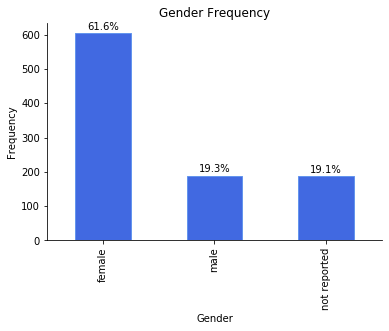

In [12]:
gender_counts = demographic.gender.value_counts()
gender_labels = [i/980 for i in demographic.gender.value_counts().tolist()]
gender_list = demographic.gender.value_counts().index.tolist()
plt.figure()
ax = gender_counts.plot(kind='bar',facecolor='royalblue',edgecolor='cornflowerblue')
rects = ax.patches
for rect, label in zip(rects,gender_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, '{:.1%}'.format(label),
            ha='center', va='bottom')

    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Gender Frequency')
ax.set_xlabel('Gender')
ax.set_ylabel('Frequency')
ax.set_xticklabels(gender_list)
plt.show()

In [13]:
demographic.gender.value_counts()

female          604
male            189
not reported    187
Name: gender, dtype: int64

The breakdown by 'gender' reveals that roughly 61% of user that reported gender are female, 19.3% are male and another 19.1% did not report their gender.

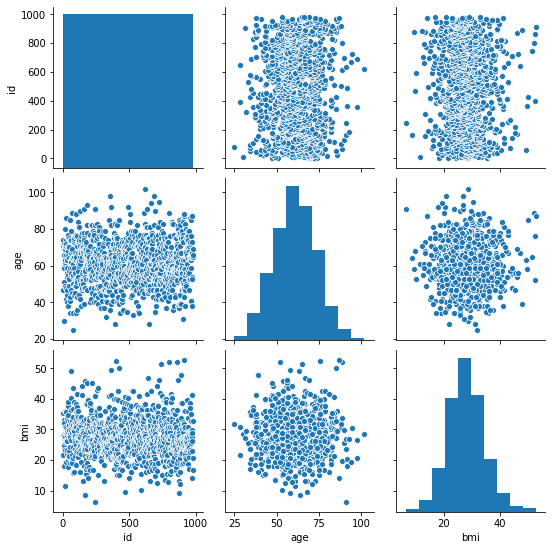

In [14]:
sns.pairplot(demographic)

The distributions for age and BMI are normal, and the bivariate scatter plot for age and BMI have no extreme outliers.

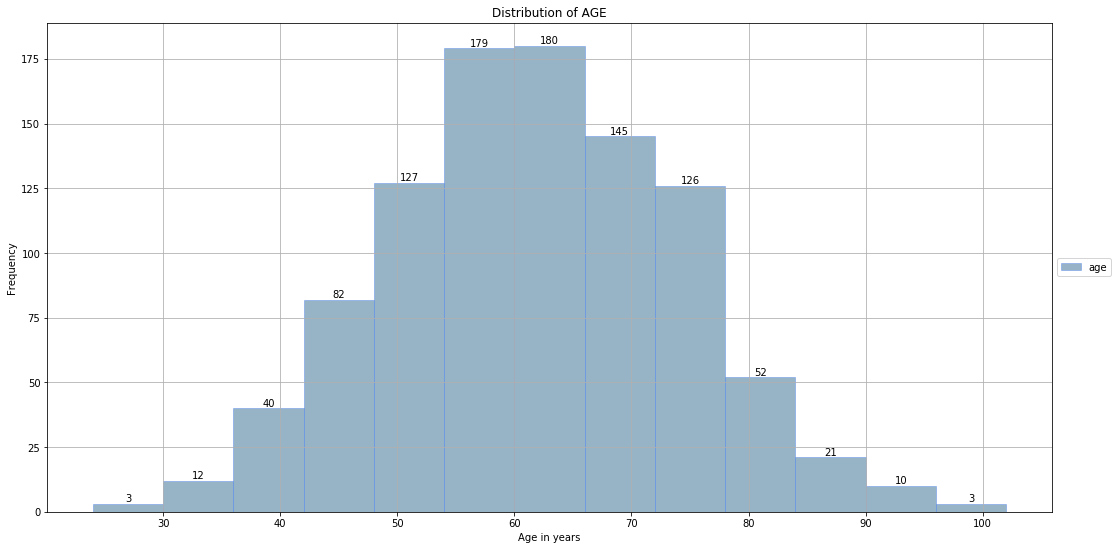

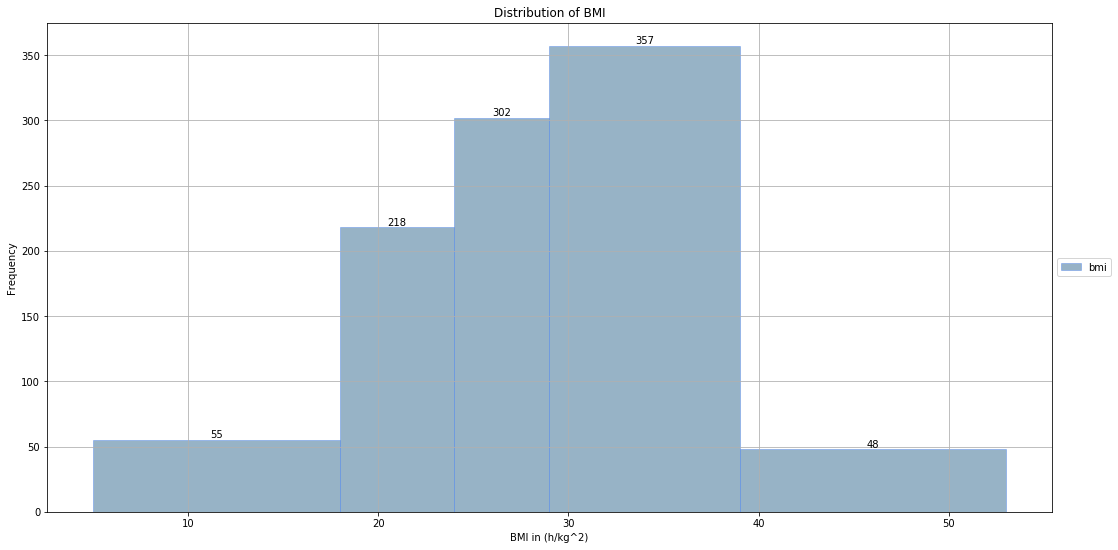

In [15]:
plt_list =['age','bmi']
bin_dict = {'age':[24,30,36,42,48,54,60,66,72,78,84,90,96,102], 'bmi': [5,18,24,29,39,53]}
unit_dict = {'age':'Age in years', 'bmi': 'BMI in (h/kg^2)'}

for item in plt_list:
    _, ax = plt.subplots(1,1,figsize=(18,9))
    cm = plt.get_cmap('viridis')
    ax.set_prop_cycle('color',[cm(1.*i/3) for i in range(1,4)])
    data = demographic['{}'.format(item)]
    freq, bins, patches = plt.hist(data, bins=bin_dict[item], label=item,edgecolor='cornflowerblue',alpha=0.5)
    bin_centers= np.diff(bins)*0.5 +bins[:-1]

    n=0
    for fq, x, path in zip(freq, bin_centers, patches):
        height= int(freq[n])
        plt.annotate("{}".format(height),
                    xy=(x,height),
                    xytext=(0,0.2),
                    textcoords = 'offset points',
                    ha='center', va='bottom')
        n+=1
    plt.legend(loc = 'center left', bbox_to_anchor =(1,0.5))
    plt.title('Distribution of {}'.format(item.upper()))
    plt.ylabel('Frequency')
    plt.xlabel('{}'.format(unit_dict[item]))
    plt.grid()
    plt.show()

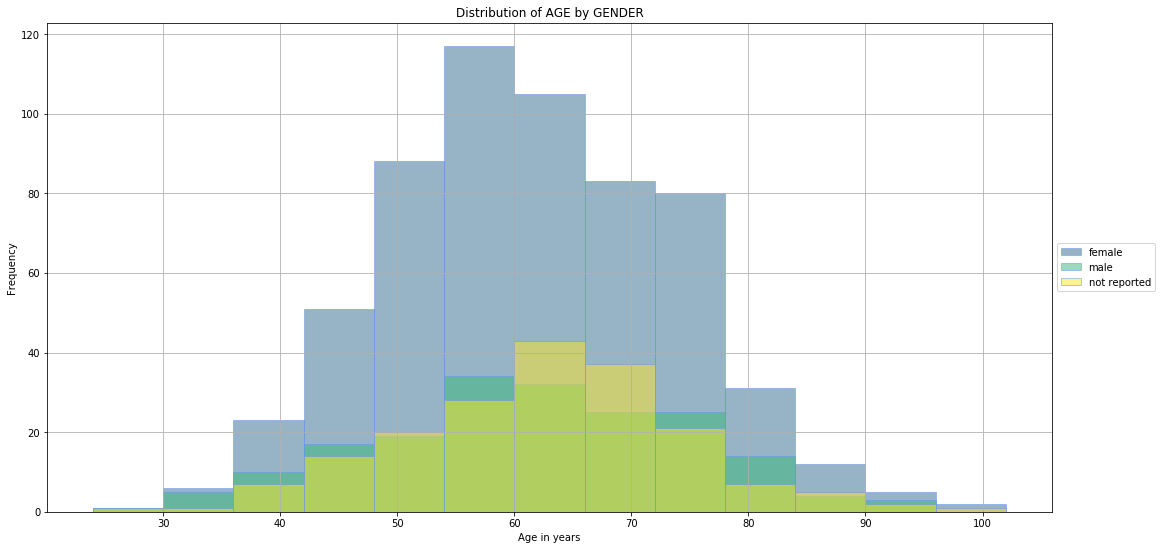

gender     female  male  not reported
age                                  
(24, 30]        1     2             1
(30, 36]        9     4             2
(36, 42]       24    14             8
(42, 48]       57    16            13
(48, 54]      101    21            23
(54, 60]      108    35            30
(60, 66]      107    32            43
(66, 72]       83    20            33
(72, 78]       70    29            21
(78, 84]       30    10             5
(84, 90]        8     3             6
(90, 96]        4     3             1
(96, 102]       2     0             1


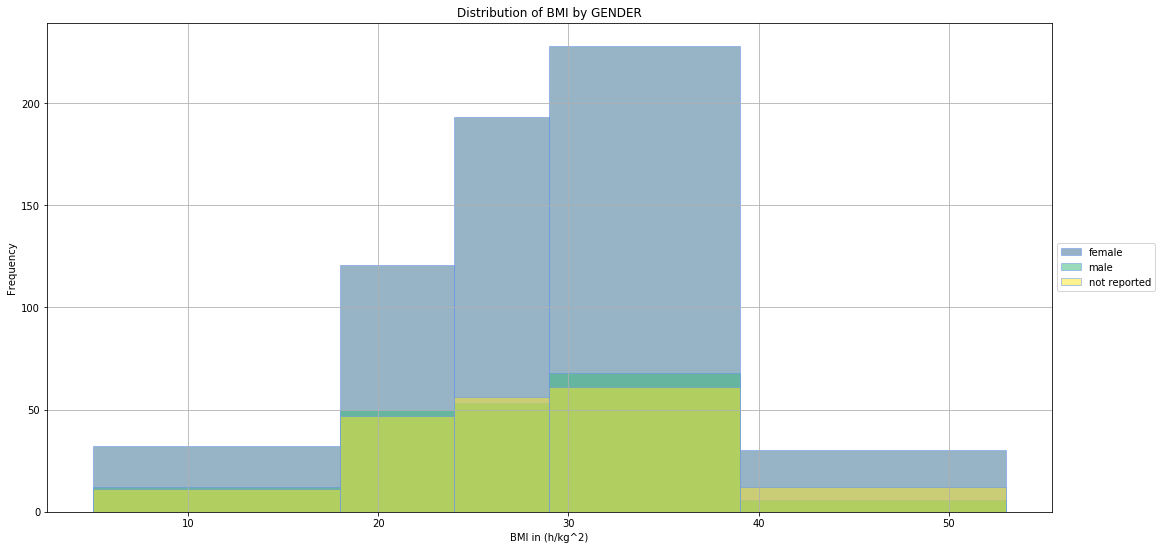

gender    female  male  not reported
bmi                                 
(5, 18]       32    12            11
(18, 24]     121    50            47
(24, 29]     193    53            56
(29, 39]     228    68            61
(39, 53]      30     6            12


In [18]:
plt_list =['age','bmi']
bin_dict = {'age':[24,30,36,42,48,54,60,66,72,78,84,90,96,102], 'bmi': [5,18,24,29,39,53]}
unit_dict = {'age':'Age in years', 'bmi': 'BMI in (h/kg^2)'}

for item in plt_list:
    _, ax = plt.subplots(1,1,figsize=(18,9))
    cm = plt.get_cmap('viridis')
    ax.set_prop_cycle('color',[cm(1.*i/3) for i in range(1,4)])
    for gender in reversed(demographic.gender.unique()):
        
        data = demographic[(demographic.gender==gender)]['{}'.format(item)]
        freq, bins, patches = plt.hist(data, bins=bin_dict[item], label=gender,edgecolor='cornflowerblue',alpha=0.5)
        bin_centers= np.diff(bins)*0.5 +bins[:-1]

        n=0
        for fq, x, path in zip(freq, bin_centers, patches):
            height= int(freq[n])
            """plt.annotate("{}".format(height),
                        xy=(x,height),
                        xytext=(0,0.2),
                        textcoords = 'offset points',
                        ha='center', va='bottom')"""
            n+=1
        plt.legend(loc = 'center left', bbox_to_anchor =(1,0.5))
        plt.title('Distribution of {} by GENDER'.format(item.upper()))
        plt.ylabel('Frequency')
        plt.xlabel('{}'.format(unit_dict[item]))
        plt.grid()
    plt.show()
    print(pd.crosstab(pd.cut(demographic['{}'.format(item)], bins=bin_dict[item]),demographic.gender))


Further breaking down age and BMI by gender shows normally distributed data with minor variations and shifts.

In [ ]:
"""
stacked histograms of demographic breakdown for age and bmi categories


plt_list =['age','bmi']
bin_dict = {'age':[24,30,36,42,48,54,60,66,72,78,84,90,96,102], 'bmi': [5,18,24,29,39,53]}
unit_dict = {'age':'Age in years', 'bmi': 'BMI in (h/kg^2)'}

for item in plt_list:
    demographic.pivot(columns='gender')['{}'.format(item)].plot(kind='hist', bins=bin_dict[item], stacked=True, density=True, figsize=(18,9), edgecolor='black')
    plt.legend(loc = 'center left', bbox_to_anchor =(1,0.5))
    plt.title('Distribution of {}'.format(item.upper()))
    plt.ylabel('Frequency')
    plt.xlabel('{}'.format(unit_dict[item]))
    plt.grid()
    plt.show()
    print(pd.crosstab(pd.cut(demographic['{}'.format(item)], bins=bin_dict[item]),demographic.gender))
"""

In [19]:
pd.crosstab([pd.cut(demographic.age,bins=[24,30,36,42,48,54,60,66,72,78,84,90,96,102]),pd.cut(demographic.bmi,bins=[5,18,24,29,39,53])],demographic.gender)
#cross tabulation by age and bmi index for recorded genders.

gender              female  male  not reported
age       bmi                                 
(24, 30]  (18, 24]       1     0             0
          (24, 29]       0     1             0
          (29, 39]       0     1             1
(30, 36]  (5, 18]        0     1             0
          (18, 24]       1     1             1
          (24, 29]       4     1             0
          (29, 39]       4     1             1
(36, 42]  (5, 18]        1     1             1
          (18, 24]       5     1             2
          (24, 29]       7     6             4
          (29, 39]      10     5             1
          (39, 53]       1     1             0
(42, 48]  (5, 18]        0     1             0
          (18, 24]      13     6             2
          (24, 29]      14     3             3
          (29, 39]      25     6             6
          (39, 53]       5     0             2
(48, 54]  (5, 18]        5     2             2
          (18, 24]      23     8             8
          (24, 29]      27     5             4
          (29, 39]      41     4             9
          (39, 53]       5     2             0
(54, 60]  (5, 18]        6     3             2
          (18, 24]      24     9             7
          (24, 29]      36    14             8
          (29, 39]      37     8            10
          (39, 53]       5     1             3
(60, 66]  (5, 18]        5     2             3
          (18, 24]      23     6             9
          (24, 29]      38     9            17
          (29, 39]      38    15            12
          (39, 53]       3     0             2
(66, 72]  (5, 18]        6     1             2
          (18, 24]      13     5            11
          (24, 29]      29     5             9
          (29, 39]      30     9            10
          (39, 53]       5     0             1
(72, 78]  (5, 18]        5     1             1
          (18, 24]      10     8             5
          (24, 29]      27     7             7
          (29, 39]      25    12             7
          (39, 53]       3     1             1
(78, 84]  (5, 18]        1     0             0
          (18, 24]       7     4             0
          (24, 29]       8     0             3
          (29, 39]      12     5             1
          (39, 53]       2     1             1
(84, 90]  (5, 18]        1     0             0
          (18, 24]       0     0             1
          (24, 29]       0     1             1
          (29, 39]       6     2             2
          (39, 53]       1     0             2
(90, 96]  (5, 18]        2     0             0
          (18, 24]       1     2             0
          (24, 29]       1     1             0
          (29, 39]       0     0             1
(96, 102] (18, 24]       0     0             1
          (24, 29]       2     0             0

### Part 2: Patient Progress

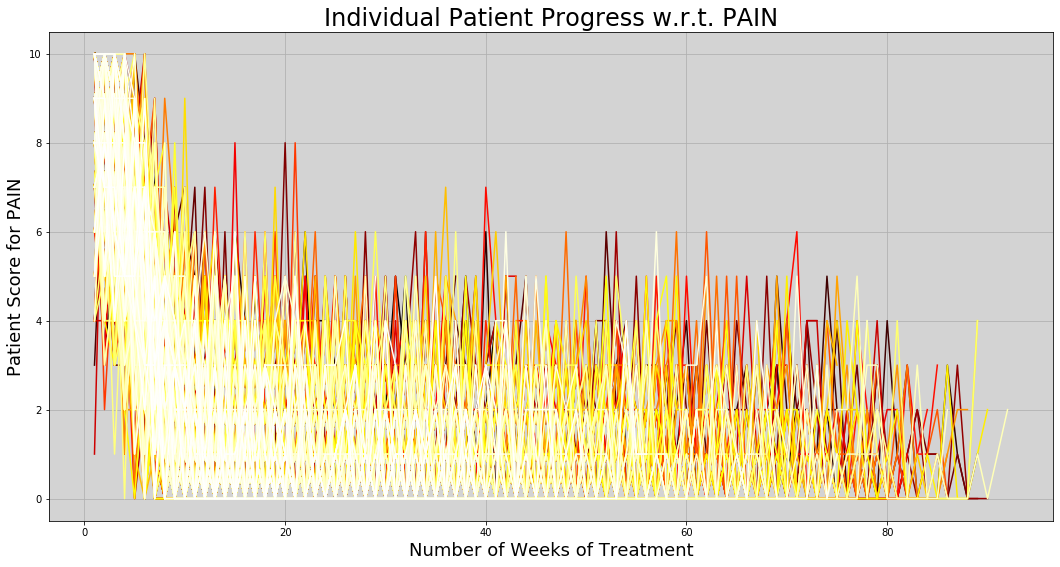

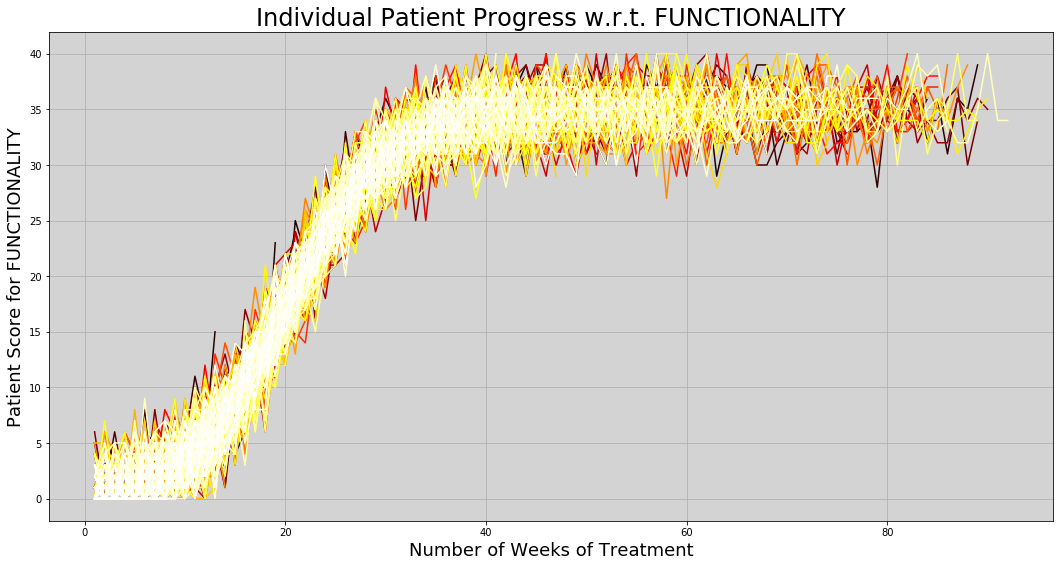

In [15]:
for metric in ['pain','functionality']:
    _, ax = plt.subplots(1,1,figsize=(18,9))
    num_colors = len(cleaned_df.id.unique())
    cm = plt.get_cmap('hot')
    ax.set_prop_cycle('color', [cm(1.*i/num_colors) for i in range(num_colors)])
    ax.set_facecolor('lightgray')
    for patient in cleaned_df.id.unique():
        data = cleaned_df[(cleaned_df['id']==patient)&(cleaned_df['signed_up_at'] >='2019-01-01')]
        ax.plot(data['week_nbr'], data['{}'.format(metric)],label=patient)
    plt.title('Individual Patient Progress w.r.t. {}'.format(metric.upper()),fontsize=24)
    plt.xlabel('Number of Weeks of Treatment', fontsize=18)
    plt.ylabel('Patient Score for {}'.format(metric.upper()),fontsize=18)
    plt.grid()
    plt.show()

Both graphs show progress in pain reduction and functionality improvement at around week 10. At about week 25 there is a noticeable drop in patient data with corresponds with a majority of patients reaching a plateau with functionality improvement. At this point however there are still occasional high spikes in pain. A second drop in patient reporting occurs at about week 45, then again after week 60 the number of patients dwindles consistently.

It would appear that the longer a patient reports information the lower their report pain score becomes.

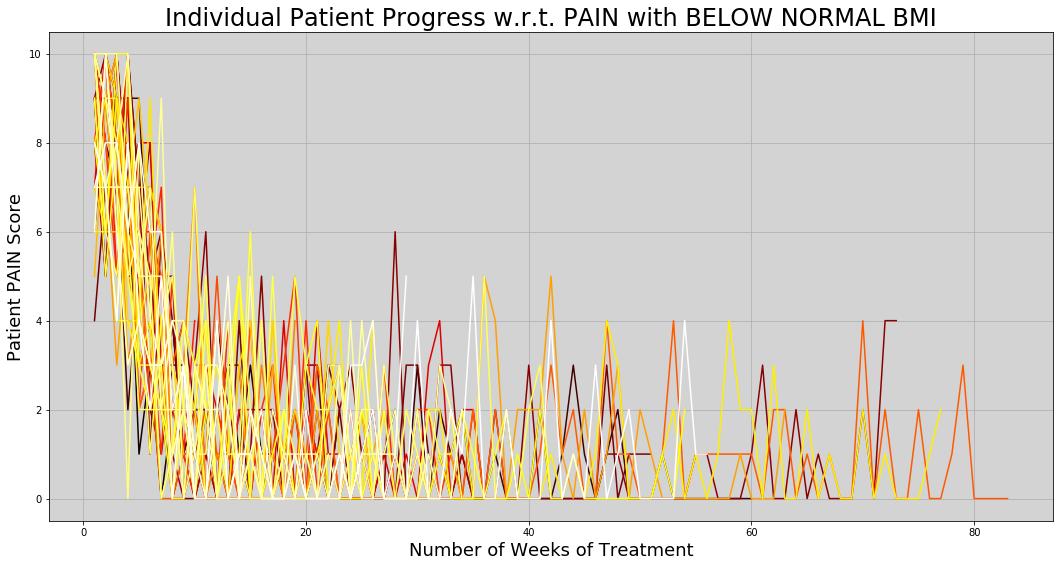

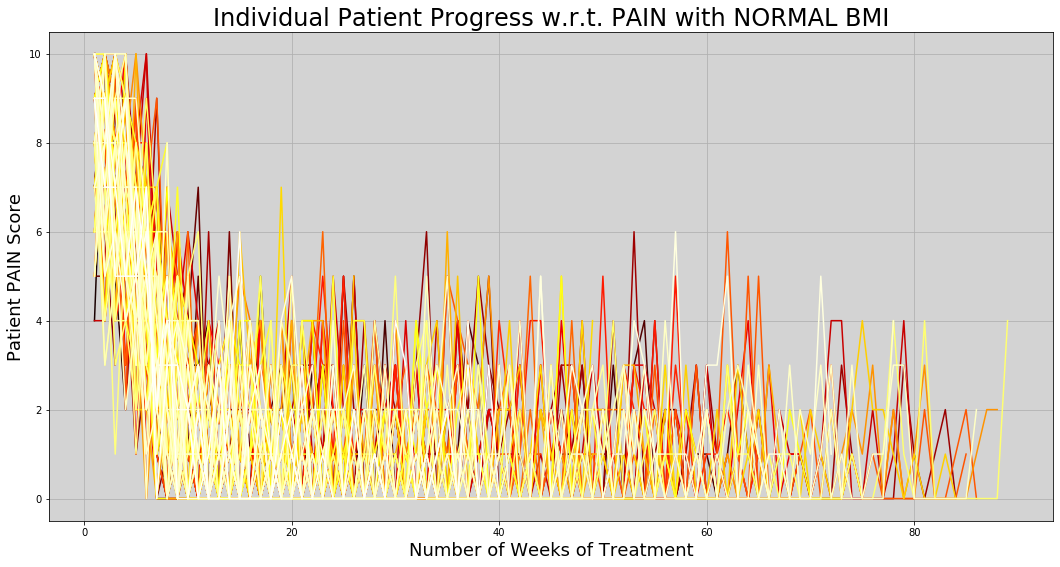

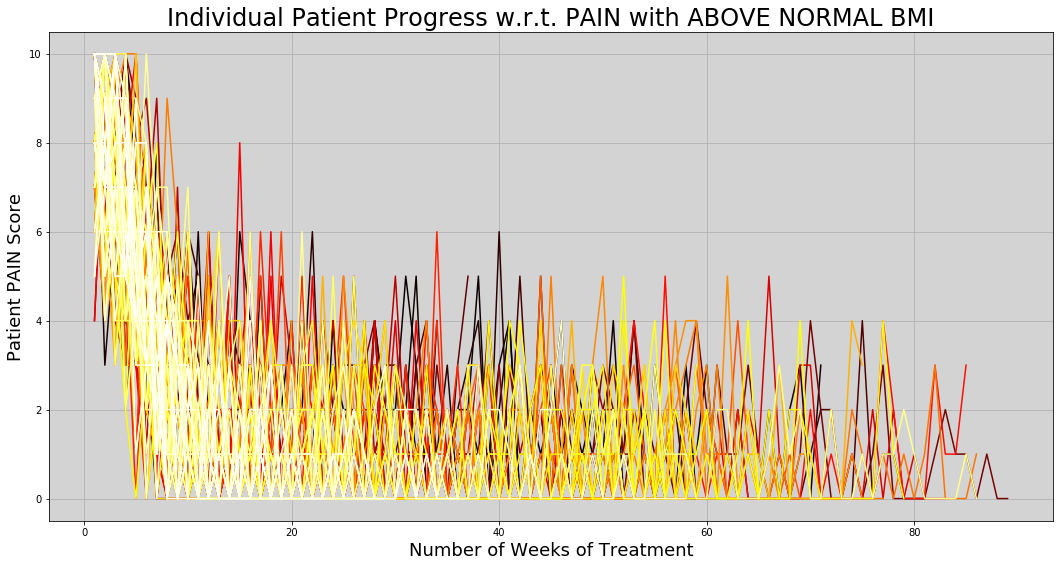

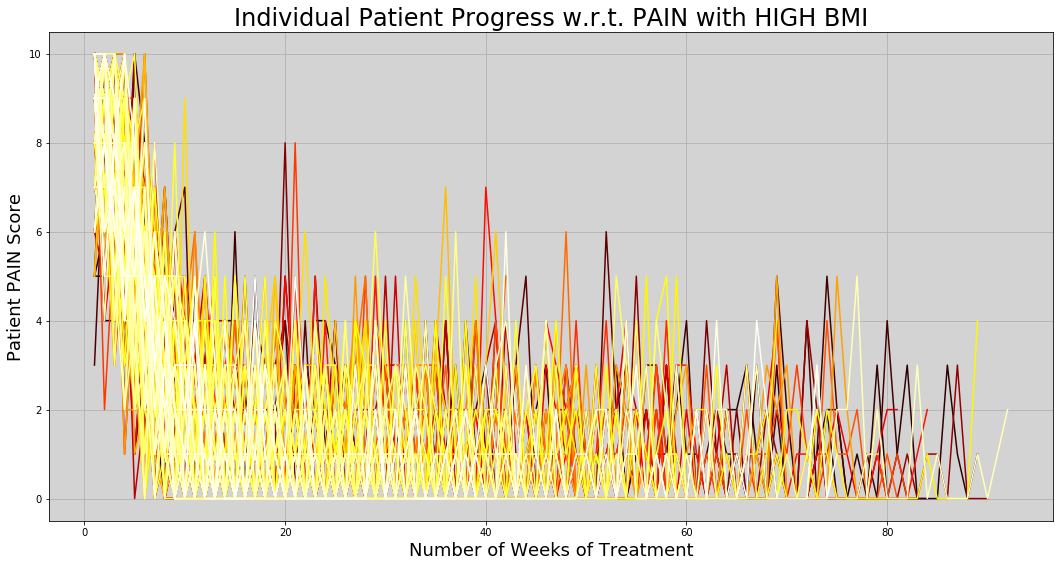

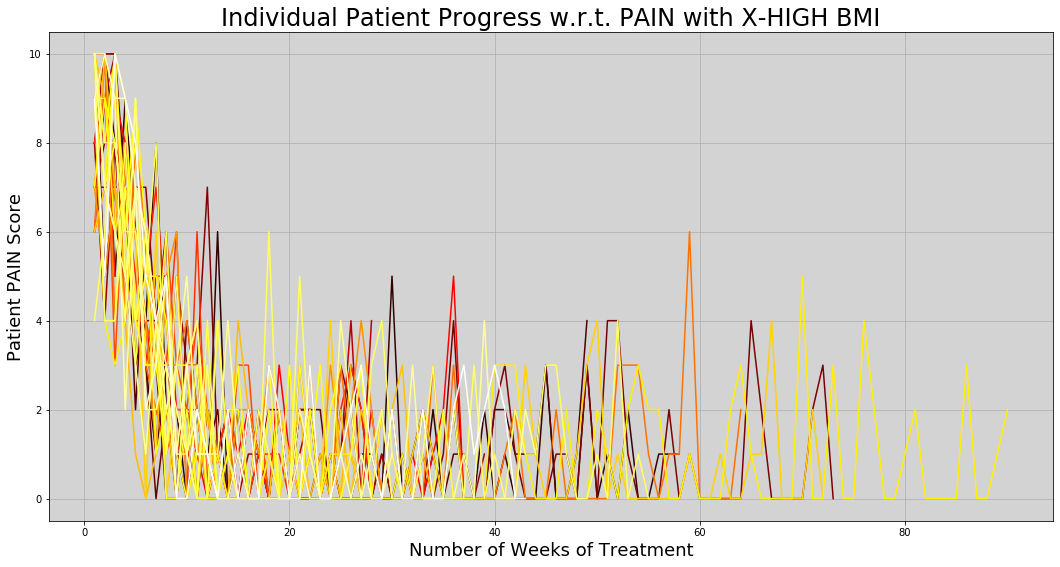

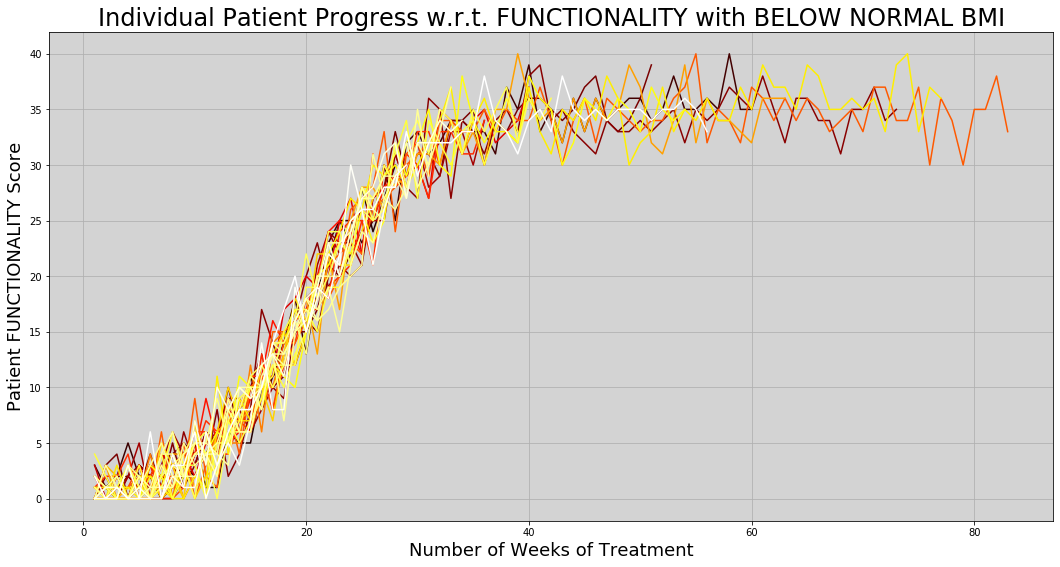

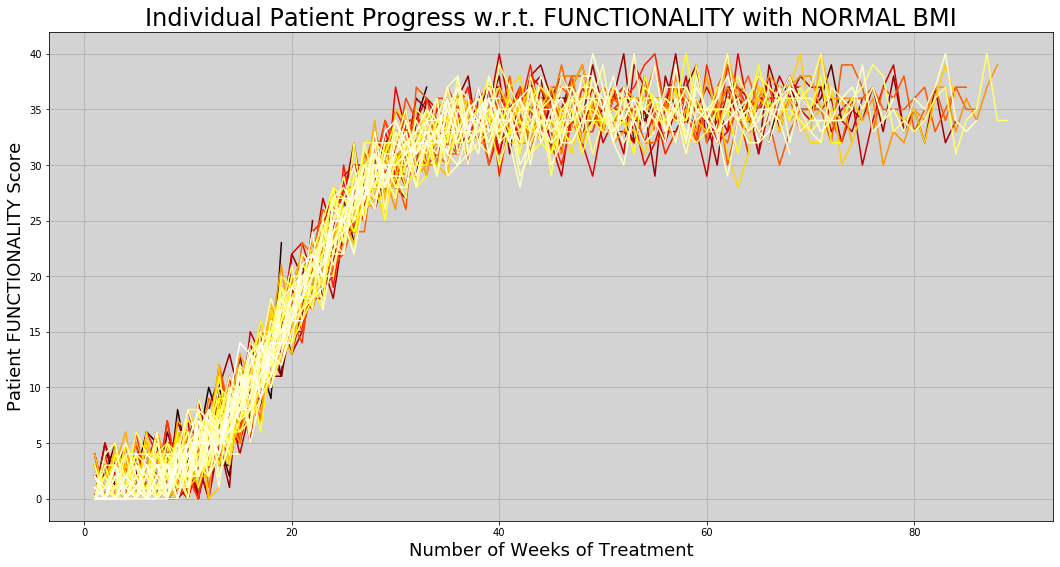

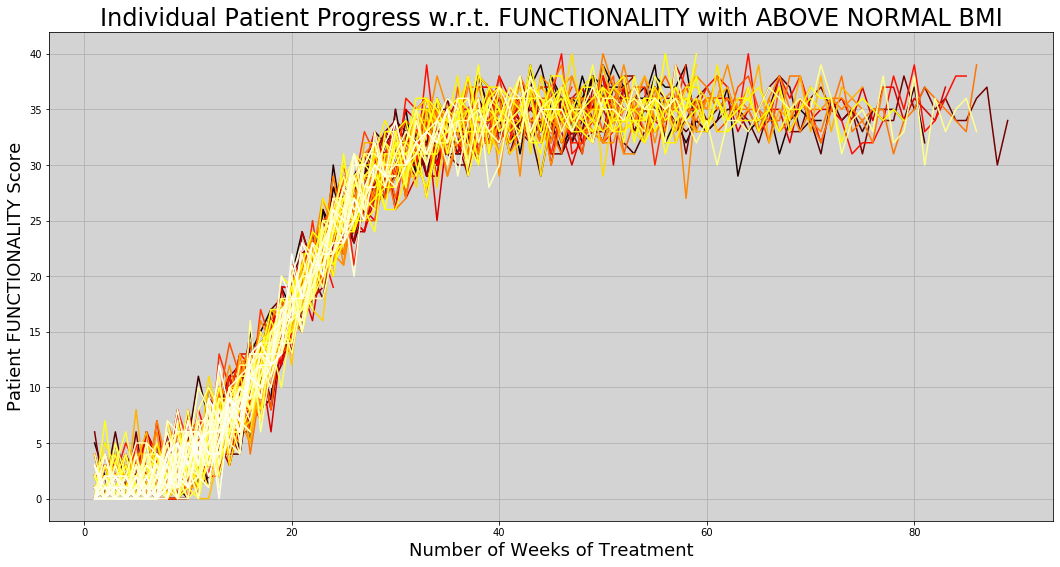

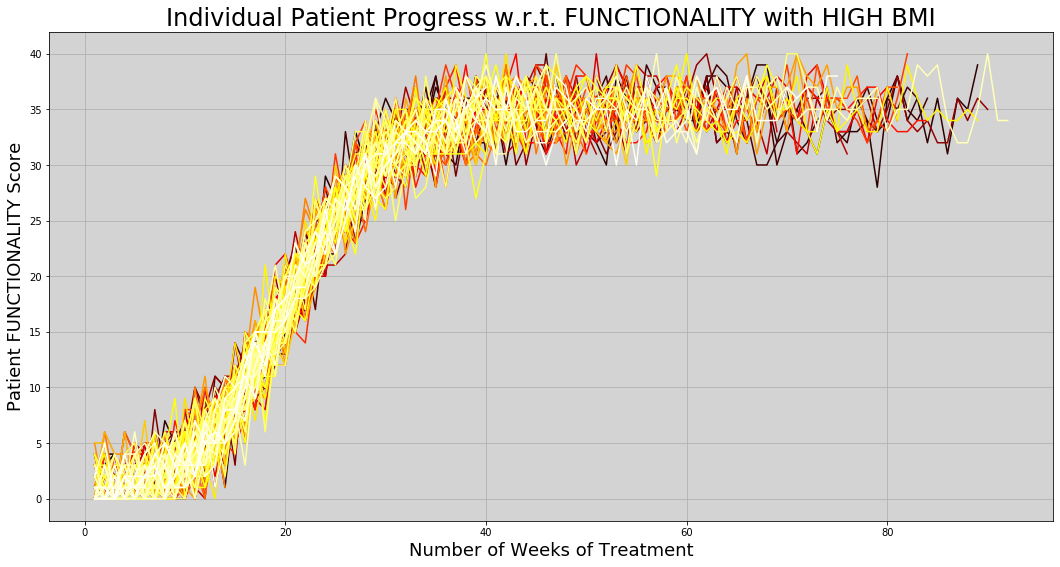

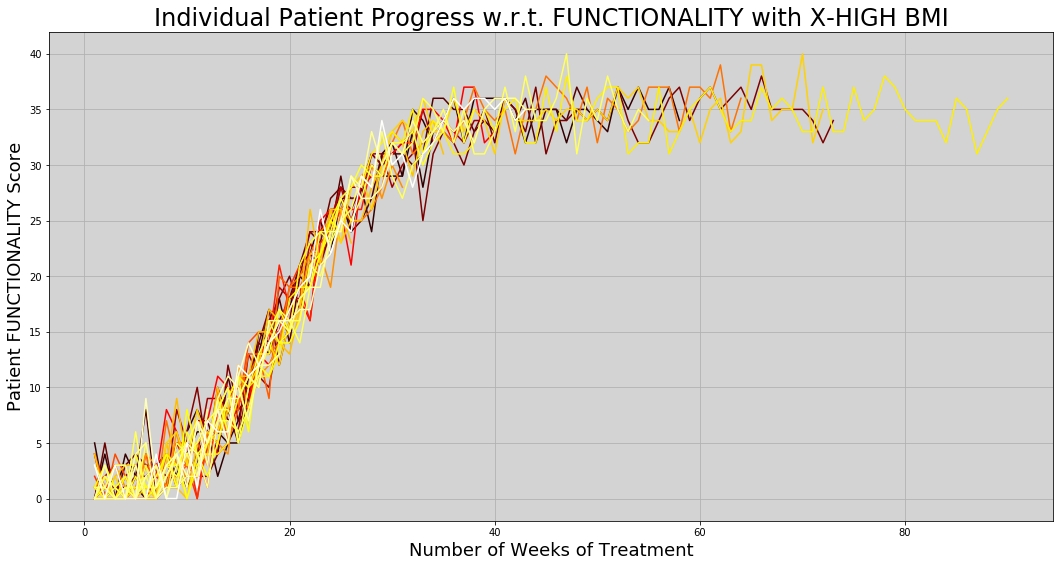

In [16]:
bmi_list = ['below normal', 'normal', 'above normal', 'high', 'x-high']
bmi_dict = {'below normal':[5,18], 'normal':[19,24], 'above normal':[25,29], 'high':[30,39], 'x-high':[40,53]}

for metric in ['pain','functionality']:
    for category in bmi_list:
        _, ax = plt.subplots(1,1,figsize=(18,9))
        num_colors = len(cleaned_df.id.unique())
        cm = plt.get_cmap('hot')
        ax.set_prop_cycle('color', [cm(1.*i/num_colors) for i in range(num_colors)])
        ax.set_facecolor('lightgray')
        for patient in cleaned_df.id.unique():
            data = cleaned_df[(cleaned_df['id']==patient)&(cleaned_df['signed_up_at'] >='2019-01-01')&(cleaned_df['bmi'] > bmi_dict[category][0])&(cleaned_df['bmi'] <= bmi_dict[category][1])]
            ax.plot(data['week_nbr'], data['{}'.format(metric)],label=patient)
        plt.title('Individual Patient Progress w.r.t. {} with {} BMI'.format(metric.upper(),category.upper()),fontsize=24)
        plt.xlabel('Number of Weeks of Treatment', fontsize=18)
        plt.ylabel('Patient {} Score'.format(metric.upper()),fontsize=18)
        plt.grid()
        plt.show()

Each BMI range shows the same downward trend in pain and the same upward trend in functionality and the same level of patient retention as time goes on.

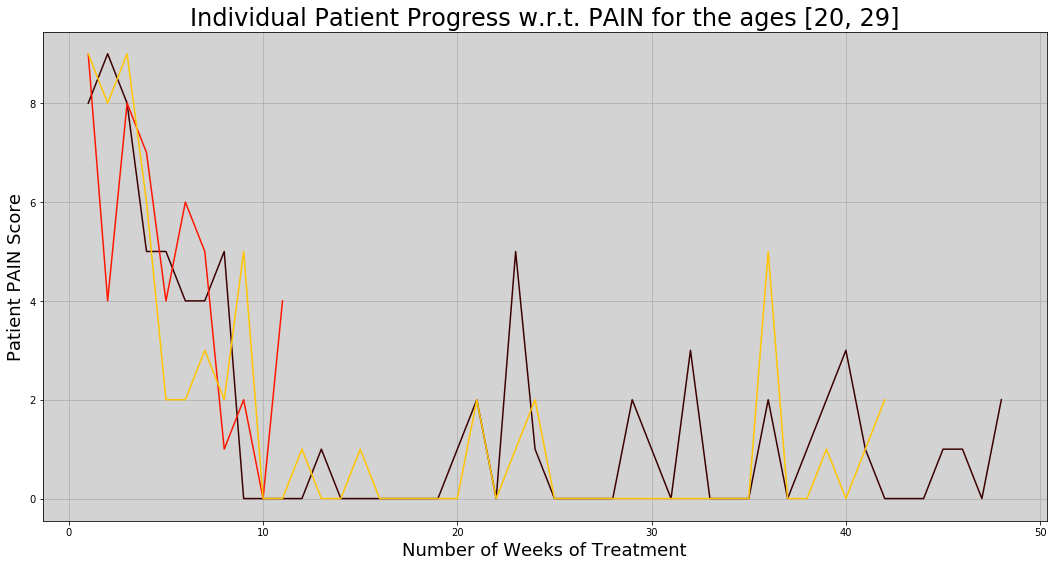

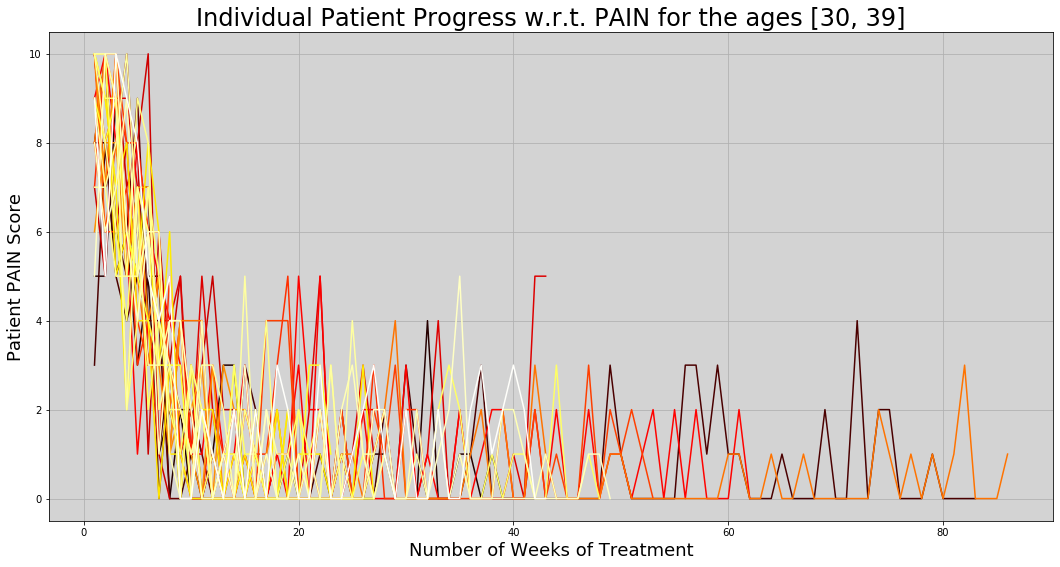

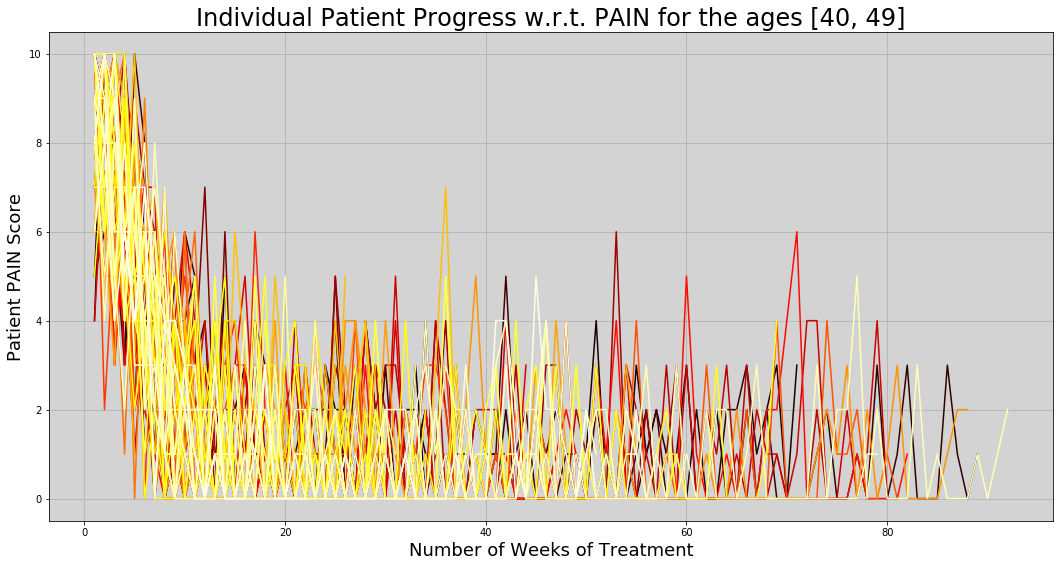

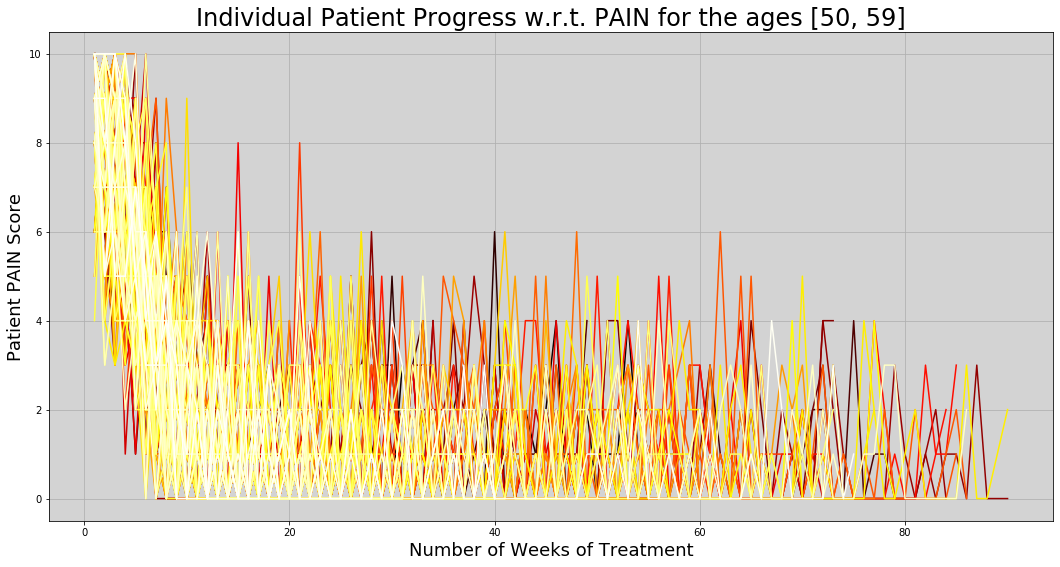

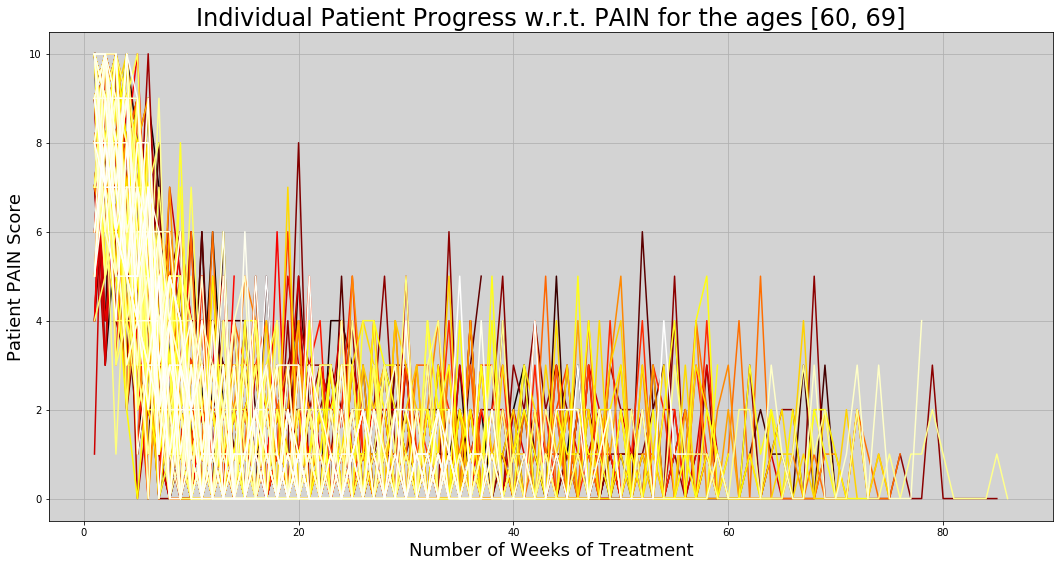

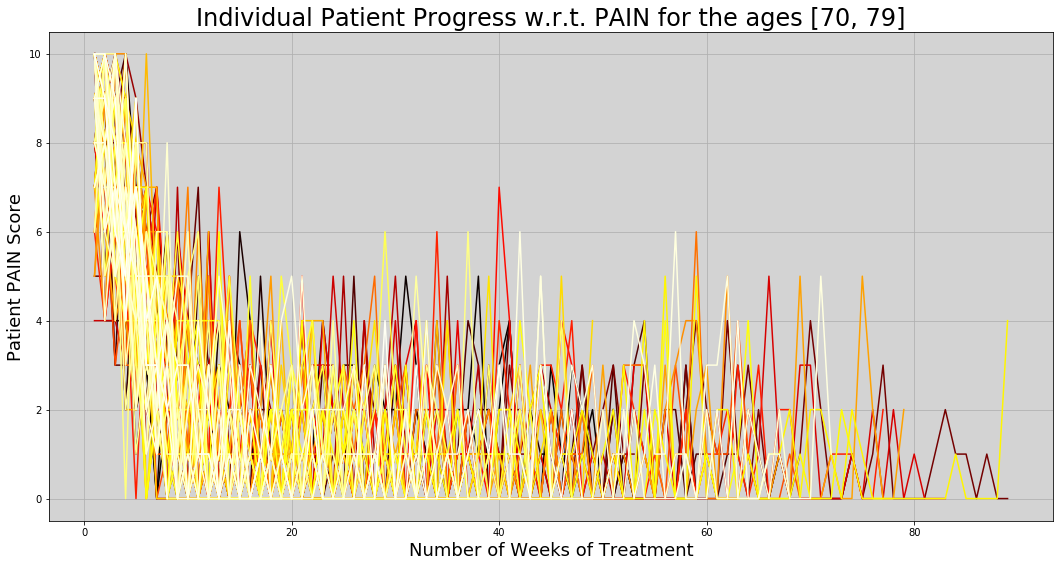

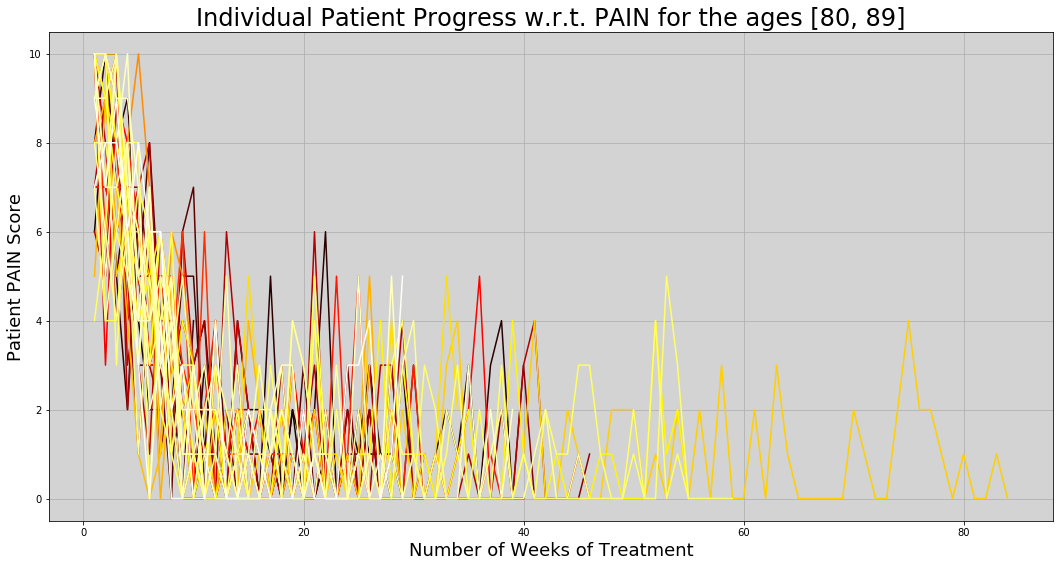

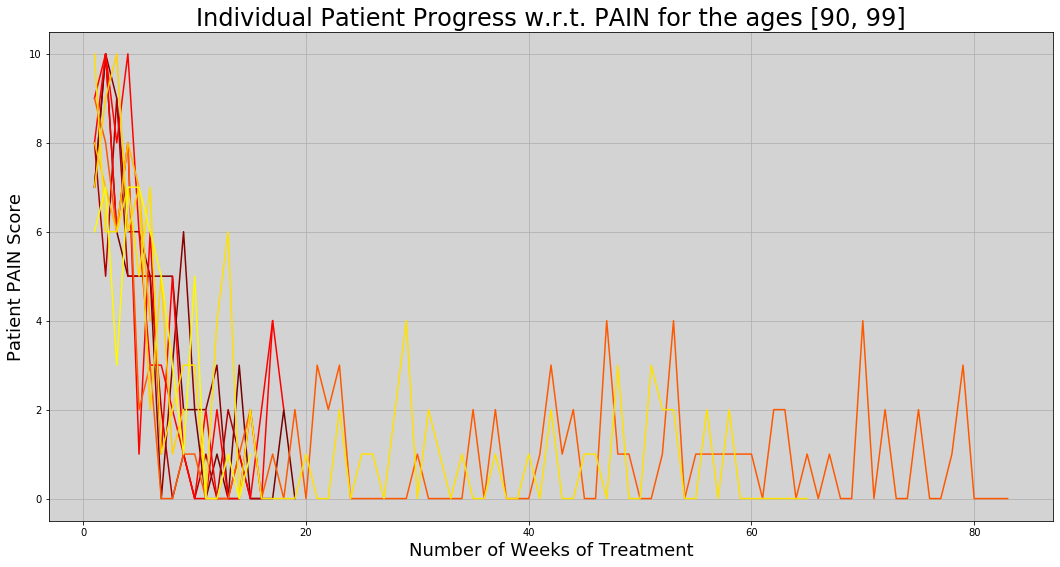

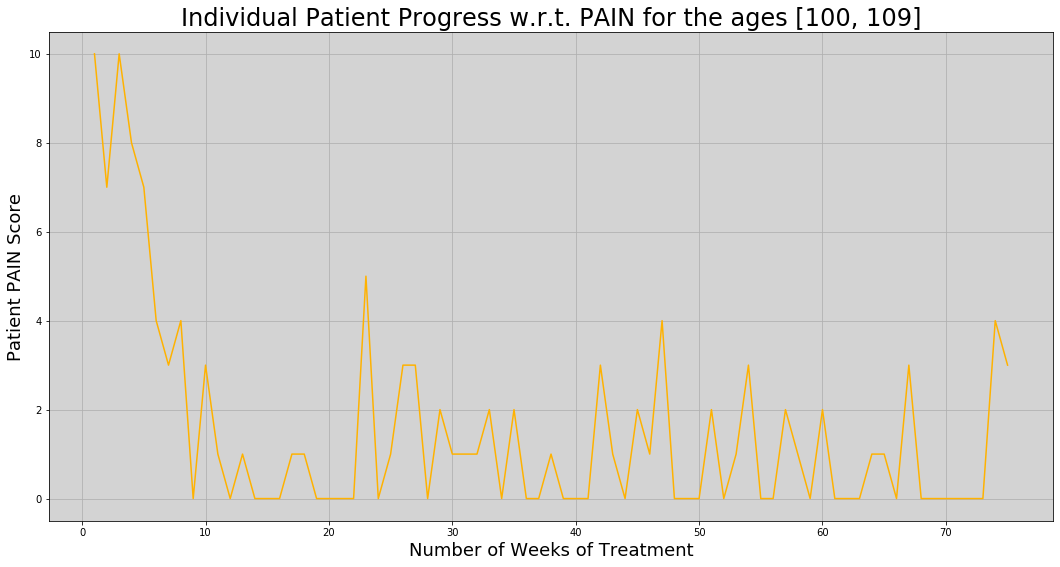

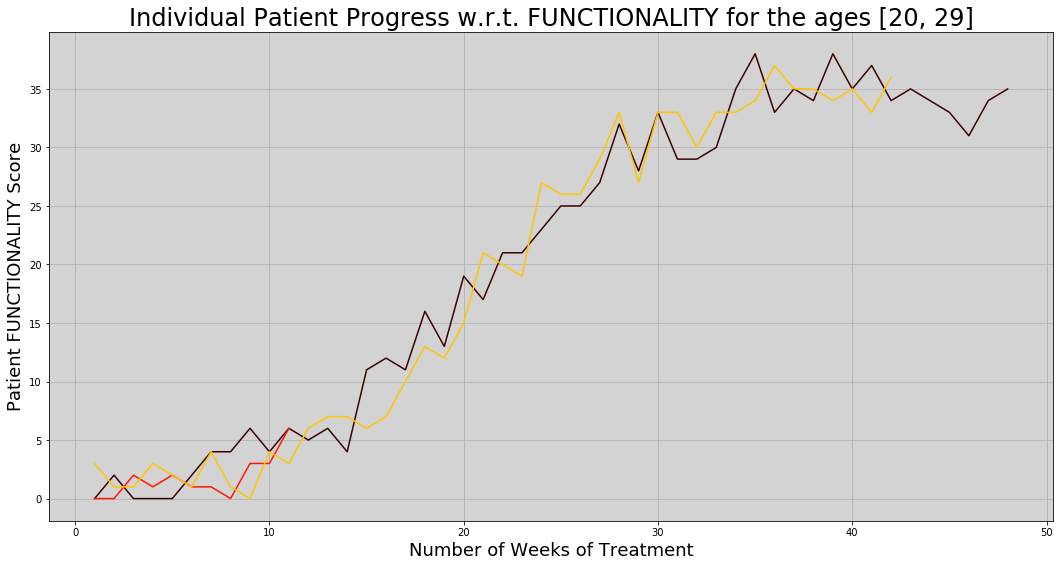

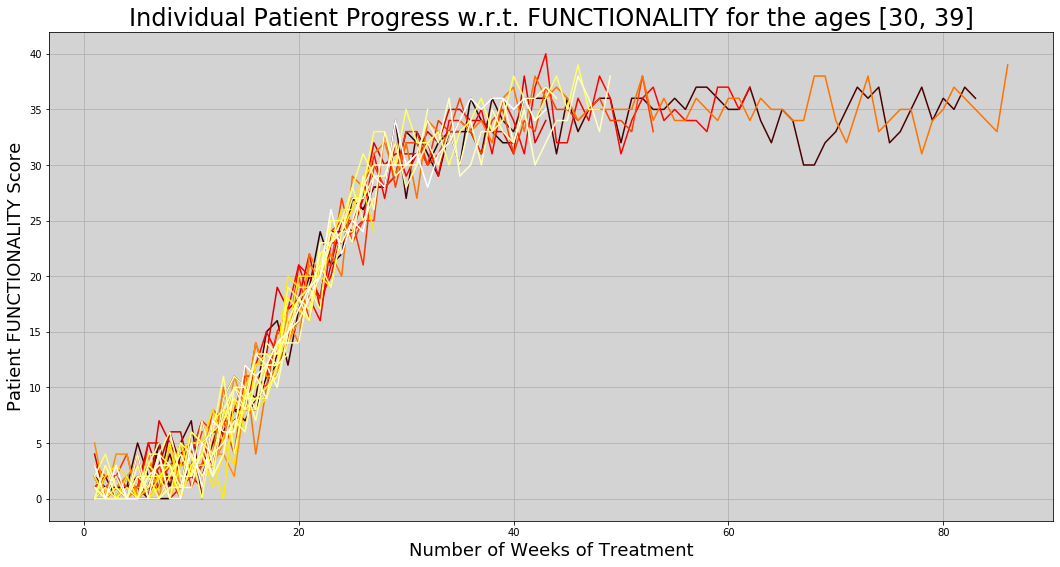

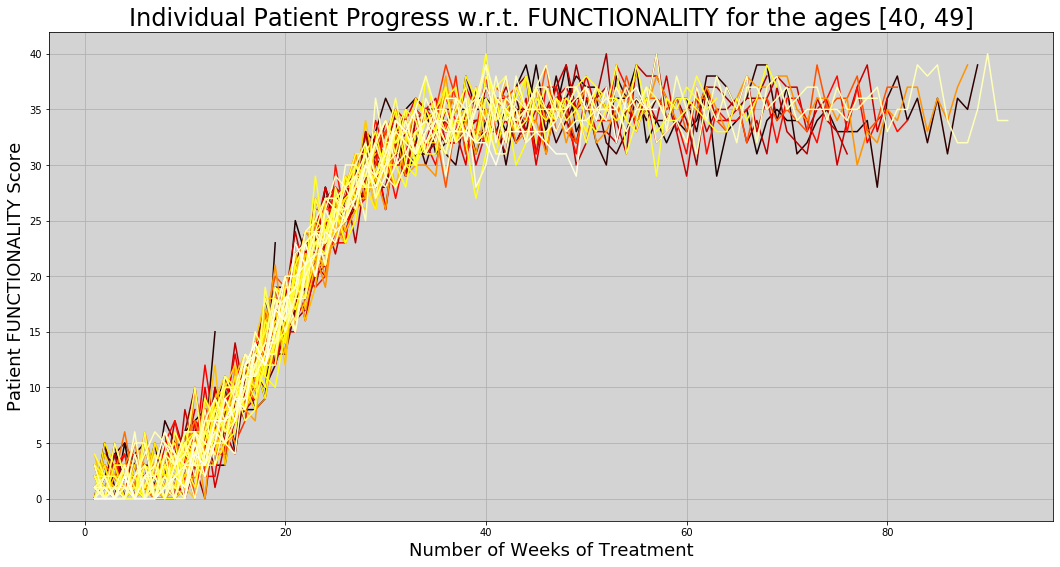

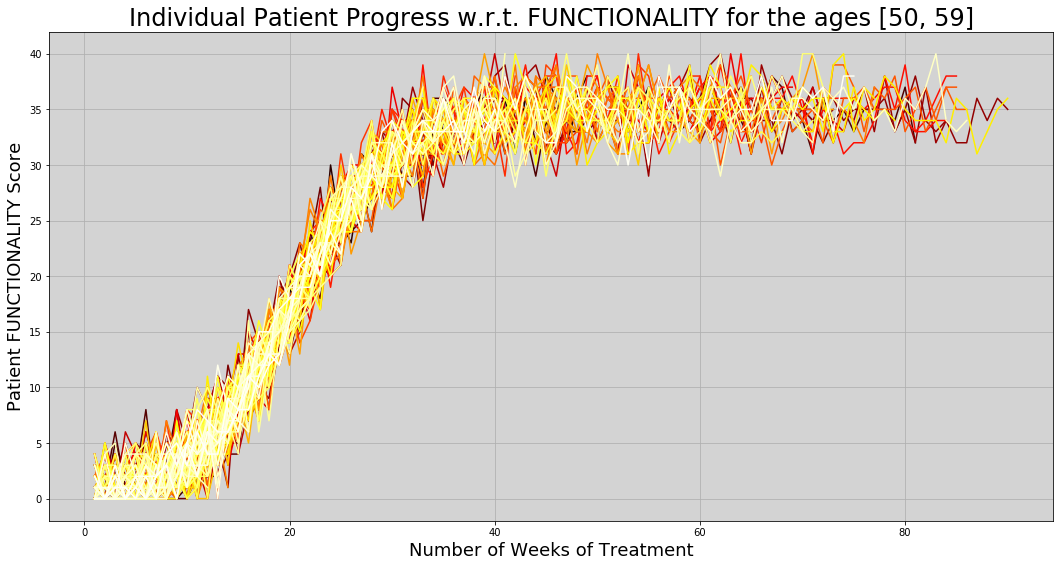

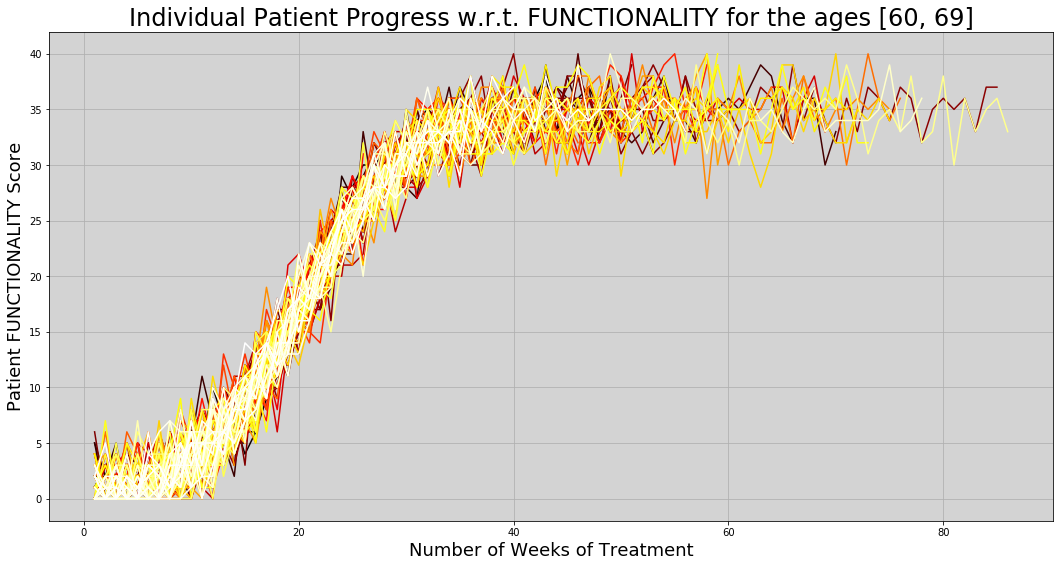

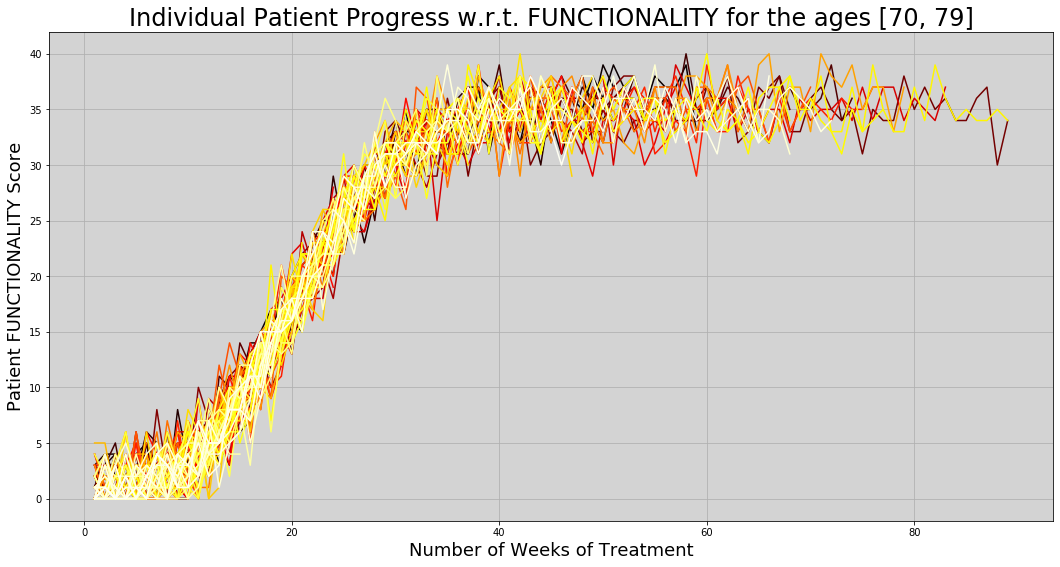

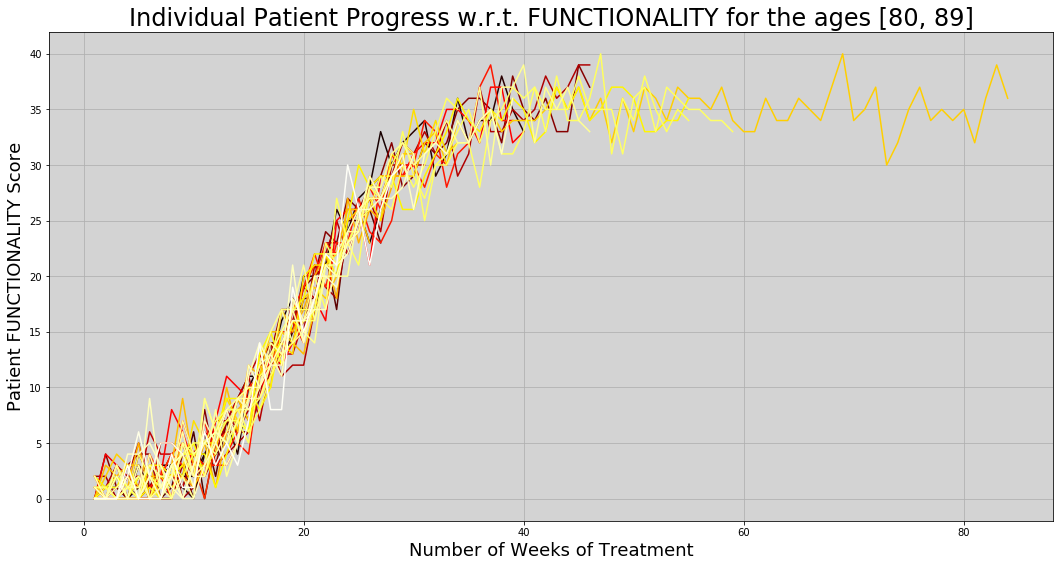

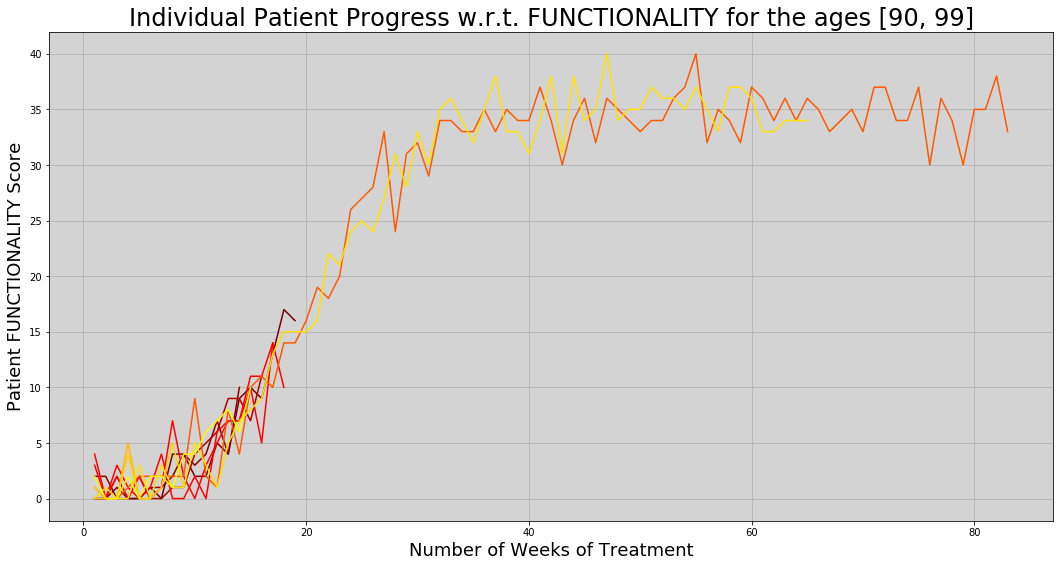

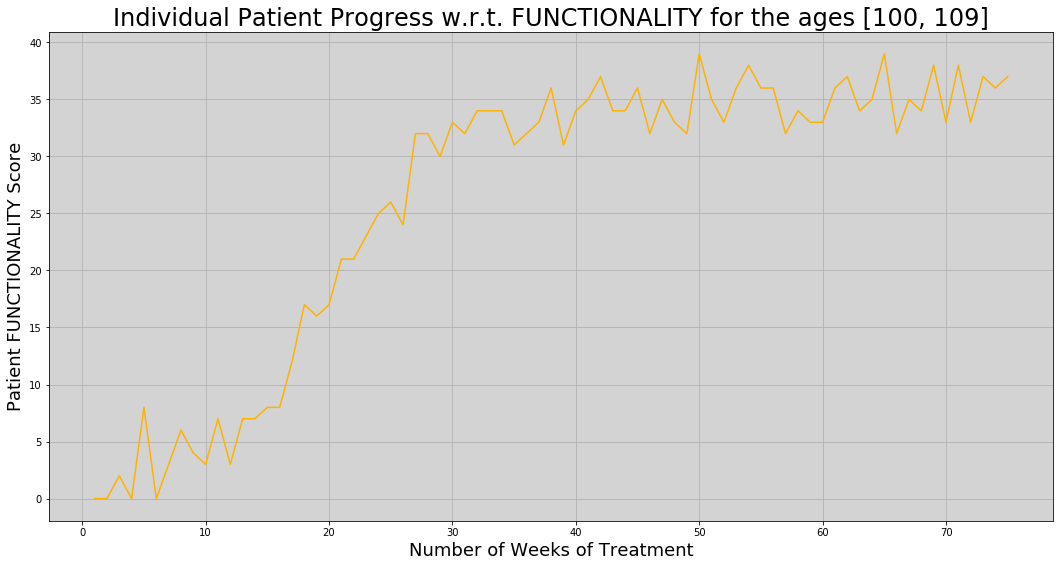

In [28]:
age_list = ['twenties','thirties','fourties','fifties','sixties','seventies','eighties','nineties','hundreds']
age_dict = {'twenties': [20,29], 'thirties': [30,39], 'fourties': [40,49], 'fifties': [50,59], 'sixties': [60,69], 'seventies': [70,79], 'eighties': [80,89], 'nineties': [90,99], 'hundreds': [100,109]}

for metric in ['pain','functionality']:
    for agegroup in age_list:
        _, ax = plt.subplots(1,1,figsize=(18,9))
        num_colors = len(cleaned_df.id.unique())
        cm = plt.get_cmap('hot')
        ax.set_prop_cycle('color', [cm(1.*i/num_colors) for i in range(num_colors)])
        ax.set_facecolor('lightgray')
        for patient in cleaned_df.id.unique():
            data = cleaned_df[(cleaned_df['id']==patient)&(cleaned_df['signed_up_at'] >='2019-01-01')&(cleaned_df['age'] > age_dict[agegroup][0])&(cleaned_df['age'] <= age_dict[agegroup][1])]
            ax.plot(data['week_nbr'], data['{}'.format(metric)],label=patient)
        plt.title('Individual Patient Progress w.r.t. {} for the ages {}'.format(metric.upper(),age_dict[agegroup]),fontsize=24)
        plt.xlabel('Number of Weeks of Treatment', fontsize=18)
        plt.ylabel('Patient {} Score'.format(metric.upper()),fontsize=18)
        plt.grid()
        plt.show()

Breaking down patient progress with respect to age by 10 year intervals shows the same upward trend in fuctionality and the same downward trend in pain. Breaking down by age shows finer resolution in terms of patient participation over time. In the more populous categories there are significant drops in participation around week 40. 

## Export:
### Final Table

In [17]:
max_df = cleaned_df.groupby(['id'])['week_nbr'].agg('max')
min_df = cleaned_df.groupby(['id'])['week_nbr'].agg('min')
max_metrics = pd.merge(max_df,cleaned_df,how='inner',on=['id','week_nbr'])
min_metrics = pd.merge(min_df,cleaned_df,how='inner',on=['id','week_nbr'])

In [18]:
diff_df = max_metrics[['id','signed_up_at','age','week_nbr','pain','functionality']].copy()
diff_df['pain_reduction'] = diff_df.pain - min_metrics.pain
diff_df['functionality_improvement'] = diff_df.functionality - min_metrics.functionality
diff_df = diff_df.drop(['pain','functionality'],axis=1)
diff_df.rename(columns={'id':'patient_id','week_nbr':'current_week_number'},inplace=True)

In [19]:
diff_df = diff_df[diff_df['signed_up_at'] >= '2019-01-01']

In [20]:
diff_df.to_csv('patient_changes.csv', index=False)